<a href="https://colab.research.google.com/github/marigflores/ai-studies/blob/main/cancer_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Detecção de Câncer de Pulmão em Imagens Médicas com Deep Learning


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Cancer-DeepLearning.pdf to Cancer-DeepLearning.pdf


In [ ]:
# falta ajeitar a metade final do modelo pro google colab
#  Import compressed files when they are too many then just unzip it
#  !unzip modelo.zip
#  !unzip dados.zip

Objetivo: Treinar/Testar um modelo de Deep Learning com arquitetura de Rede Neural Convolucional.


### Carregando os Pacotes

In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [ ]:
#!pip install -q -U matplotlib==3.2.1
#!pip install -q -U cv2==4.2.0
#!pip install -q -U numpy==1.18.4
#!pip install -q -U tensorflow==2.2.0
#!pip install -q -U keras==2.3.1
#!pip install -q -U imutils

In [ ]:
print(keras.__version__)

2.15.0


In [ ]:
# Imports
import os
import sys
import cv2
import random
import tensorflow
import keras
import itertools
import matplotlib as m
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras import layers
from keras import activations
from tensorflow.keras.utils import img_to_array
from keras.utils import to_categorical # best practice cause importing keras modules doesnt include all submodules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import imutils
from imutils import paths
import argparse


# deleted and changed some imports

In [ ]:
# Versões dos pacotes usados neste jupyter notebook -- wtf??
%reload_ext watermark
%watermark --iversions

ModuleNotFoundError: No module named 'watermark'

### Carregando as Imagens

In [ ]:
# Diretório das imagens em disco
imagens_treino = "./dados/treino/"

In [ ]:
# Listas para as imagens e labels
imagens = []
labels = []

In [ ]:
# Lista as imagens e faz o shuffle (embaralha)
imagePaths = sorted(list(paths.list_images(imagens_treino)))
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
# Loop pelas imagens e leitura com OpenCV
for imagePath in imagePaths:

    # Leitura da imagem
    image = cv2.imread(imagePath)

    # Redimensionamento para 40x40 pixels
    image = cv2.resize(image, (40,40))

    # Converte a imagem para array
    image = img_to_array(image)

    # Adiciona à lista de imagens
    imagens.append(image)

    # Extrai o label
    label = imagePath[-7:-4]

    # Define o valor 0 ou 1 para o label
    if label == "pos":
        label = 1
    else:
        label = 0

    # Adiciona à lista de labels
    labels.append(label)

In [ ]:
# Normalização das imagens
imagens = np.array(imagens, dtype = "float") / 255.0

In [ ]:
# Carrega os labels
labels = np.array(labels)

In [ ]:
# Labels
labels

array([0, 0, 1, ..., 0, 0, 1])

Vamos visualizar algumas imagens.

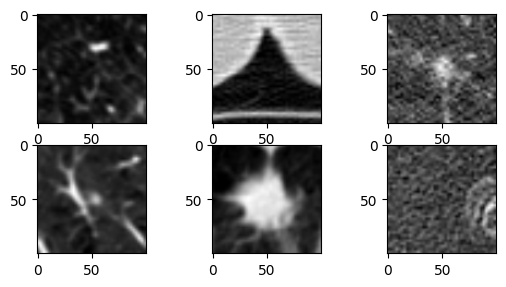

In [ ]:
# Plot das imagens
for i, images in enumerate(imagePaths[:6]):
    img = cv2.imread(images)
    img = cv2.resize(img, (100, 100))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.grid(False)
plt.show()

### Pré-Processamento das Imagens

In [ ]:
# Divisão em treino/teste com proporção 75/25
(x_treino, x_teste, y_treino, y_teste) = train_test_split(imagens, labels, test_size = 0.25, random_state = 42)

In [ ]:
# Shape
# Formato = número de imagens x altura x largura x número de canais de cores
x_treino.shape

(2206, 40, 40, 3)

In [ ]:
# Shape
# Formato = número de imagens x altura x largura x número de canais de cores
x_teste.shape

(736, 40, 40, 3)

Vamos deixar a variável de saída (label) como tipo categórico aplicando o One-Hot Encoding.

In [ ]:
# One-Hot Encoding
y_treino = to_categorical(y_treino, num_classes = len(labels))
y_teste = to_categorical(y_teste, num_classes = len(labels))

Por fim, criamos o gerador de imagens para o treinamento.

In [ ]:
# Gerador de imagens
aug = ImageDataGenerator(rotation_range = 30,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         shear_range = 0.2,
                         zoom_range = 0.2,
                         horizontal_flip = True,
                         fill_mode = "nearest")

### Construção do Modelo

In [ ]:
# Hiperparâmetros

# Número de épocas
epochs = 50

# Taxa de aprendizagem
lr = 1e-3

# Tamanho do batch
batch_size = 32

In [ ]:
# Modelo CNN
class ModeloCNN:

    @staticmethod
    def build(width, height, depth, classes):

        # Cria a sequência de camadas
        model = Sequential()

        # Shape de entrada
        inputShape = (height, width, depth)

        # Formato das imagens
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # Primeira camada convolucional com ativação Relu e MaxPooling
        model.add(Conv2D(20, (5, 5), padding = "same", input_shape = inputShape))
        # model.add(Activation("relu"))
        model.add(layers.Activation(activations.relu))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

        # Segunda camada convolucional com ativação Relu e MaxPooling
        model.add(Conv2D(50, (5, 5), padding = "same"))
        # model.add(Activation("relu"))
        model.add(layers.Activation(activations.relu))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

        # Primeirca camada totalmente conectada com ativação Relu
        model.add(Flatten())
        model.add(Dense(500))
        # model.add(Activation("relu"))
        model.add(layers.Activation(activations.relu))

        # Camada de saída com classificação softmax
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [ ]:
# Cria o modelo
modelo_cnn = ModeloCNN.build(width = 40, height = 40, depth = 3, classes = len(labels))

In [ ]:
# Cria o otimizador com algoritmo Adam
# otimizador = Adam(lr = lr, decay = lr / epochs)
otimizador = keras.optimizers.Adam(learning_rate=lr)

In [ ]:
# Compila o modelo com o otimizador, função de custo e métricas
modelo_cnn.compile(optimizer = otimizador, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
# Sumário do modelo
modelo_cnn.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

### Treinamento

In [ ]:
# Treina o modelo

print("\nIniciando o Treinamento...\n")

hist = modelo_cnn.fit_generator(aug.flow(x_treino, y_treino, batch_size = batch_size),
                                validation_data = (x_teste, y_teste),
                                steps_per_epoch = len(x_treino) // batch_size,
                                epochs = epochs,
                                verbose = 1)

print("\nTreinamento Concluído.\n")


Iniciando o Treinamento...



<ipython-input-69-e4ed57b589a2>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = modelo_cnn.fit_generator(aug.flow(x_treino, y_treino, batch_size = batch_size),


Epoch 1/50
68/68 [==============================] - 16s 210ms/step - loss: 0.8686 - accuracy: 0.7213 - val_loss: 0.5381 - val_accuracy: 0.7242
Epoch 2/50
68/68 [==============================] - 14s 206ms/step - loss: 0.4601 - accuracy: 0.7870 - val_loss: 0.3728 - val_accuracy: 0.8288
Epoch 3/50
68/68 [==============================] - 14s 203ms/step - loss: 0.3872 - accuracy: 0.8473 - val_loss: 0.3204 - val_accuracy: 0.8655
Epoch 4/50
68/68 [==============================] - 15s 214ms/step - loss: 0.3595 - accuracy: 0.8588 - val_loss: 0.3061 - val_accuracy: 0.8818
Epoch 5/50
68/68 [==============================] - 14s 202ms/step - loss: 0.3361 - accuracy: 0.8643 - val_loss: 0.2972 - val_accuracy: 0.8818
Epoch 6/50
68/68 [==============================] - 14s 207ms/step - loss: 0.3197 - accuracy: 0.8763 - val_loss: 0.2787 - val_accuracy: 0.8886
Epoch 7/50
68/68 [==============================] - 14s 204ms/step - loss: 0.2932 - accuracy: 0.8919 - val_loss: 0.2480 - val_accuracy: 0.9049

### Avaliando o Modelo

In [ ]:
# Calculamos a performance do modelo com dados de teste
score = modelo_cnn.evaluate(x_teste, y_teste, verbose = 1)

23/23 [==============================] - 2s 73ms/step - loss: 0.1235 - accuracy: 0.9470


In [ ]:
print("Acurácia do Modelo em Teste: %0.2f" % score[1])

Acurácia do Modelo em Teste: 0.95


### Relatório de Classificação

In [ ]:
print(classification_report(predY, y_teste))

NameError: name 'predY' is not defined

In [ ]:
# Salva o modelo
modelName = "./modelo/modelo_cnn.model"
modelo_cnn.save(modelName)

FailedPreconditionError: ./modelo/modelo_cnn.model is not a directory

### Testar o modelo

In [ ]:
# Define o local da imagem (outras imagens estão disponíveis para teste)
image = "./dados/teste/imagem2_cancer.png"

In [ ]:
# Define o local do modelo
model = "./modelo/modelo_cnn.model"

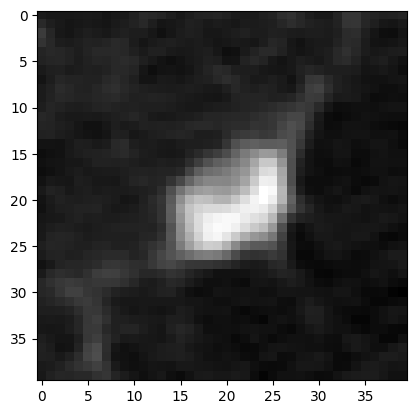

In [ ]:
# Carrega a imagem
image = cv2.imread(image)
orig = image.copy()
plt.imshow(image)
plt.show()

In [ ]:
# Pré-processamento da imagem
image = cv2.resize(image, (40, 40))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis = 0)

In [ ]:

# Carrega o modelo treinado
model = load_model(model)

NameError: name 'load_model' is not defined

In [ ]:
# Fazemos a previsão
score = model.predict(image)[0]

# Extraímos a classe da previsão
label = model.predict_classes(image)[0]

# De acordo com o label, definimos a classificação final
if label == 0:
    label = "No Cancer"
else:
    label = "Cancer"

AttributeError: 'str' object has no attribute 'predict'

In [ ]:
#Calcular o nível de confiança
# Extrai a maior probabilidade das previsões do modelo
proba = max(score)

# Print
print("Nível de confiança = {0:.2f}%".format(proba*100))

# Output
output = imutils.resize(orig, width = 400)

# Verifica a probabilidade
if proba*100 > 95:
    out = "{}: {:.2f}%".format(label, proba * 100)
    color = (0,255,0)
else:
    out = "{}".format("Not detected")
    color = (255,0,0)

# Texo
text = cv2.putText(output, out, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

Nível de confiança = 94.70%


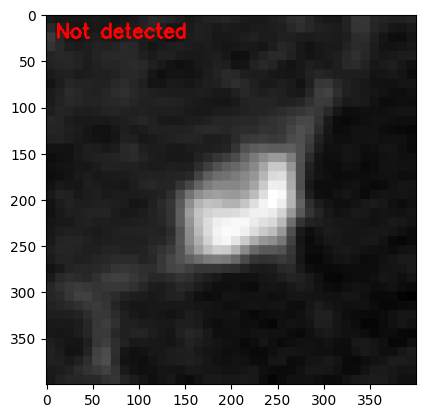

In [ ]:
plt.imshow(output)
plt.show()

# Fim